<a href="https://colab.research.google.com/github/Dev-jalexx/Pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert the MNIST Image files into 4-dimensions Tensors(Number of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Train data
train_data = datasets.MNIST(root='/cnn_data', download = True, train= True, transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]


In [4]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', download = True, train= False, transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# define our CNN model
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
#Grab 1 MNIST image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
# Transform into 4-dimension
x = X_train.view(1, 1, 28, 28)

In [12]:
# first convolutional layer
x = F.relu(conv1(x))

In [13]:
x.shape # Padding reduces the dimensions

torch.Size([1, 6, 26, 26])

In [14]:
# first pooling
x = F.max_pool2d(x, 2, 2) # kernel size of 2 and stride of 2

In [15]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [16]:
# Second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
# Second pooling
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# Model
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # Fully connected Layers
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    #Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    # Review to flatten it out/ reshape the CNN tensor from 4D to 2D
    X = X.view(-1, 16*5*5) # -1 preserves the original batch size.
    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1) # Convets output into log-probablities

In [21]:
# Instantiate our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Losss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [23]:
import time
start_time = time.time()
# Create variables for tracking
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loops of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

# Calculating the number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1] #Add up number of correct predictions
    batch_corr = (predicted == y_train).sum() # How many we got correct
    trn_corr += batch_corr

    #Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Print results
    if b%600 == 0:
      print(f'epoch: {i} batch: {b} loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]# Add up correct predictions
      tst_corr += (predicted == y_test).sum()# T=1, F=0
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time  = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes.')

epoch: 0 batch: 600 loss: 0.1623609960079193
epoch: 0 batch: 1200 loss: 0.15515124797821045
epoch: 0 batch: 1800 loss: 0.4303523004055023
epoch: 0 batch: 2400 loss: 0.12933236360549927
epoch: 0 batch: 3000 loss: 0.005222576204687357
epoch: 0 batch: 3600 loss: 0.40715670585632324
epoch: 0 batch: 4200 loss: 0.004482123535126448
epoch: 0 batch: 4800 loss: 0.0022434615530073643
epoch: 0 batch: 5400 loss: 0.02891628071665764
epoch: 0 batch: 6000 loss: 0.0003335700312163681
epoch: 1 batch: 600 loss: 0.003126084106042981
epoch: 1 batch: 1200 loss: 0.3031778931617737
epoch: 1 batch: 1800 loss: 0.0024100872687995434
epoch: 1 batch: 2400 loss: 0.0018737802747637033
epoch: 1 batch: 3000 loss: 0.0162246972322464
epoch: 1 batch: 3600 loss: 0.37820178270339966
epoch: 1 batch: 4200 loss: 0.02532477118074894
epoch: 1 batch: 4800 loss: 0.0012947404757142067
epoch: 1 batch: 5400 loss: 0.0008680702303536236
epoch: 1 batch: 6000 loss: 0.3670758008956909
epoch: 2 batch: 600 loss: 0.037437085062265396
epoch

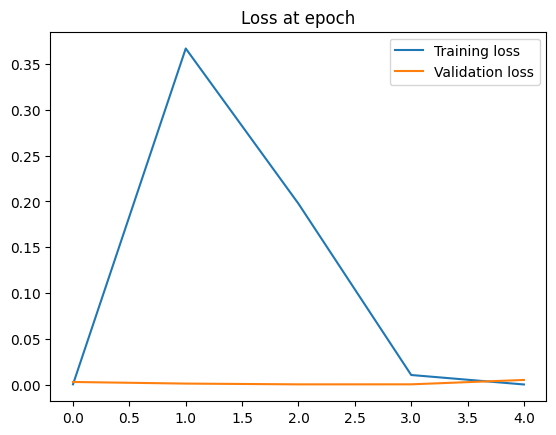

In [25]:
# Graph results
train_losses = [t.item() for t in train_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at epoch')
plt.legend()

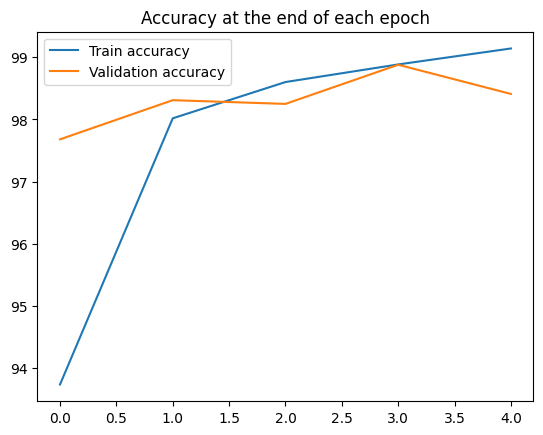

In [27]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Train accuracy')
plt.plot([t/100 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()


In [28]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [36]:
correct=0
with torch.no_grad():
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data,1)[1]
    correct+= (predicted == y_test).sum()



In [35]:
correct.item()/len(test_data)*100

98.41

In [37]:
# Grab an image
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [38]:
# Grab data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [39]:
# Reshape the data
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

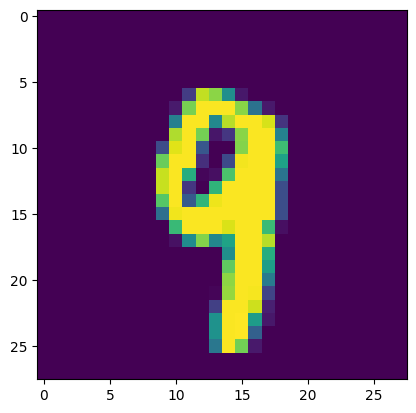

In [41]:
#show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [43]:
# run the image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28))

In [44]:
new_prediction

tensor([[-2.1949e+01, -1.7241e+01, -2.2095e+01, -1.5774e+01, -9.4154e+00,
         -1.7936e+01, -3.0714e+01, -1.1460e+01, -1.3655e+01, -9.3337e-05]])

In [46]:
new_prediction.argmax()

tensor(9)